In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize, OneHotEncoder
from sklearn.model_selection import train_test_split
from torch.autograd import Variable

In [2]:
df = pd.read_csv('../Datasets/Startup/50_Startups.csv')
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit
0,165349.20,136897.80,471784.10,New York,192261.83
1,162597.70,151377.59,443898.53,California,191792.06
2,153441.51,101145.55,407934.54,Florida,191050.39
3,144372.41,118671.85,383199.62,New York,182901.99
4,142107.34,91391.77,366168.42,Florida,166187.94


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   R&D Spend        50 non-null     float64
 1   Administration   50 non-null     float64
 2   Marketing Spend  50 non-null     float64
 3   State            50 non-null     object 
 4   Profit           50 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.1+ KB


In [4]:
enc = OneHotEncoder()
state_encoding = enc.fit_transform(df[['State']]).toarray()
state_df = pd.DataFrame(state_encoding)
df = df.join(state_df)
df.head()

,R&D Spend,Administration,Marketing Spend,State,Profit,0,1,2
0,165349.20,136897.80,471784.10,New York,192261.83,0.0,0.0,1.0
1,162597.70,151377.59,443898.53,California,191792.06,1.0,0.0,0.0
2,153441.51,101145.55,407934.54,Florida,191050.39,0.0,1.0,0.0
3,144372.41,118671.85,383199.62,New York,182901.99,0.0,0.0,1.0
4,142107.34,91391.77,366168.42,Florida,166187.94,0.0,1.0,0.0


In [5]:
y = df['Profit'].values
x_cols = df.columns.tolist()
x_cols.remove('Profit')
x_cols.remove('State')
x = np.stack([df[i].values for i in x_cols],axis=1)
y = df['Profit'].values

In [6]:
x = normalize(x)
y = normalize(y.reshape(-1,1), axis=0)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=33, shuffle=True)
x_test, x_validation, y_test, y_validation = train_test_split(x_test,y_test,test_size=0.2,random_state=33, shuffle=True)

In [8]:
x_train = torch.FloatTensor(x_train)
y_train = torch.FloatTensor(y_train)
x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)
x_validation = torch.FloatTensor(x_validation)
y_validation = torch.FloatTensor(y_validation)

In [9]:
class Model(nn.Module):
    def __init__(self, in_features=6, h1=12, h2=16, h3 = 32,  out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)# hidden layer
        self.fc3 = nn.Linear(h2, h3)# hidden layer
        self.out = nn.Linear(h3, out_features)


    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

In [10]:
model = Model()
criterion = nn.L1Loss() # good for multilayer regression similar to mse but robust to outliers.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
epochs =10000
losses = []
for i in range(epochs):
    i+=1
    optimizer.zero_grad()
    y_pred = model.forward(x_train)
    loss = criterion(y_pred, y_train)
    losses.append(loss.item())

    if i%1000 == 1:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    loss.backward()
    optimizer.step()

epoch:  1  loss: 0.34242377
epoch: 1001  loss: 0.00679416
epoch: 2001  loss: 0.00742578
epoch: 3001  loss: 0.00479511
epoch: 4001  loss: 0.00461294
epoch: 5001  loss: 0.00482605
epoch: 6001  loss: 0.00227041
epoch: 7001  loss: 0.00254853
epoch: 8001  loss: 0.00257259
epoch: 9001  loss: 0.00190597


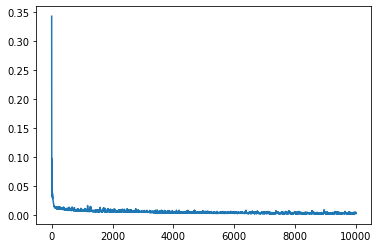

In [12]:
plt.plot(range(epochs), losses)

In [13]:
with torch.no_grad():
    y_val = model.forward(x_test)
    loss = criterion(y_val, y_test)
print(f'{loss:.8f}')

0.01966342


In [14]:
error_rate = 0.0400
correct = 0
with torch.no_grad():
    for i in range(len(x_test)):
        y_val = model.forward(x_test[i])
        if abs(y_val.item()-y_test[i].item()) < error_rate:
            correct += 1
print(f'\n{correct} out of {len(y_test)} = {100*correct/len(y_test):.2f}% correct')


6 out of 8 = 75.00% correct


In [15]:
model.eval()

Model(
  (fc1): Linear(in_features=6, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=32, bias=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)

In [16]:
with torch.no_grad():
    for i in range(len(x_validation)):
        y_val = model(x_validation[i])
        print(str(y_val) + ' : ' + str(y_validation[i]))

tensor([0.2417]) : tensor([0.2287])
tensor([0.1752]) : tensor([0.1545])
